# Transfer Learning

In this notebook, we will engage in transfer learning using the CIFAR-10 dataset with the ResNet50 model provided by Keras.

**Overview of Steps:**
- **Dataset Introduction**: CIFAR-10 consists of 32 x 32 RGB images distributed across 10 classes. We'll load this dataset directly from Keras for convenience.
- **Visualization Functions**: We'll define functions to help visualize some of these images along with their class labels. The `display_image` function will be particularly useful for seeing the images before and after processing.
- **Normalization**: For both training and validation images, normalization will be applied using the `preprocess_input` function from the ResNet50 Keras model. This step adjusts the pixel values to a range that the model expects, enhancing model training effectiveness.
- **Transfer Learning Setup**: We will utilize the ResNet50 model, initializing it with pre-trained ImageNet weights. All layers of the ResNet50 will be retained, including the final classification layers, to leverage learned features while adjusting to our specific dataset.
- **Observing Predictions**: After training, we'll evaluate the model on the validation set to observe its predictions, providing insight into its performance and accuracy.

By following these steps, we aim to efficiently adapt the powerful ResNet50 model to classify images from the CIFAR-10 dataset, demonstrating the effectiveness of transfer learning in applying pre-learned features to new, related tasks.

## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


## Defining the Parameters

In [ ]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Visualization Functions

In [ ]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data

For this notebook, we will use the CIFAR10 dataset which can be loaded from `tf.keras.datasets`

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


### Visualize Dataset

The `display_image` method we defined earlier is now going to be used display few images along with their class label

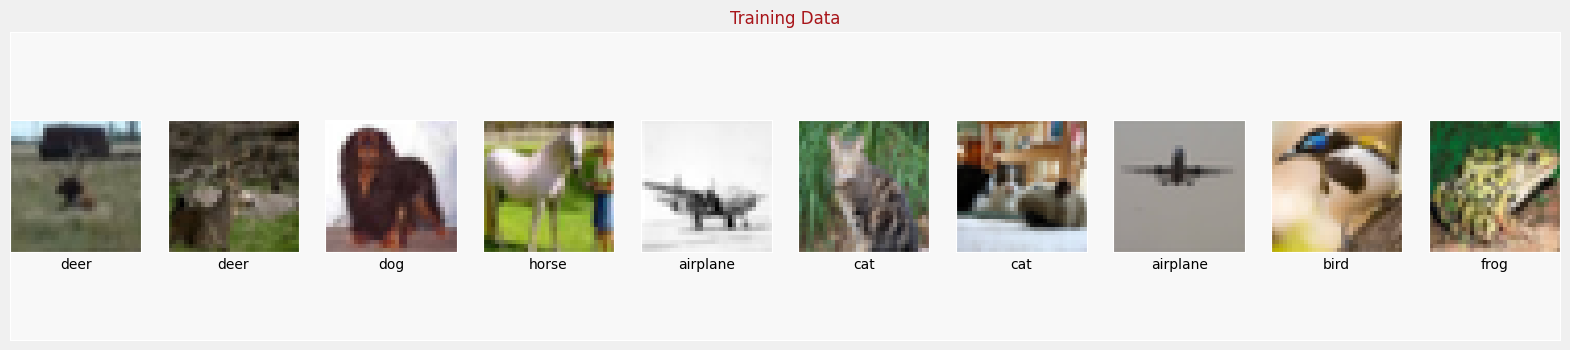

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

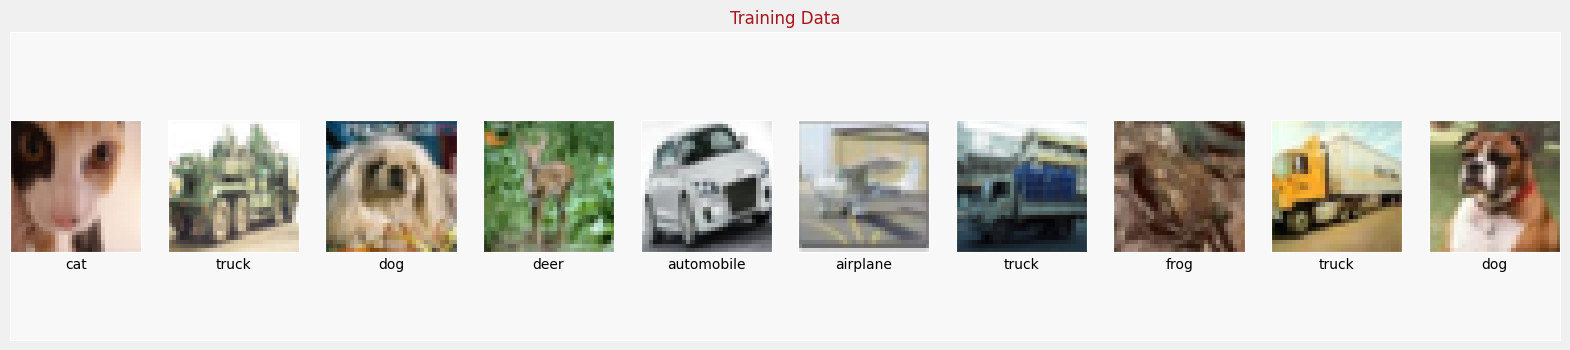

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

### Preprocess Dataset

We'll perform normalization on images in the training and validation sets.
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network

We will perform transfer learning using the **ResNet50** model provided by Keras:

- **Load Pre-trained Weights**: We'll initialize the ResNet50 model with pre-trained ImageNet weights, which provides a robust starting point for learning given the extensive variety of features these weights offer.
  
- **Retain All Layers**: All layers of the ResNet50 will be retained, including the final classification layers. This approach leverages the comprehensive architecture of ResNet50, adapting its powerful capabilities to our specific classification task with the CIFAR-10 dataset.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


# Defines final dense layers and subsequent softmax layer for classification.
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

## Train the model

In [ ]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/4
782/782 [==============================] - 582s 704ms/step - loss: 0.4060 - accuracy: 0.8692 - val_loss: 0.2072 - val_accuracy: 0.9286
Epoch 2/4
782/782 [==============================] - 546s 699ms/step - loss: 0.1052 - accuracy: 0.9660 - val_loss: 0.1963 - val_accuracy: 0.9327
Epoch 3/4
782/782 [==============================] - 546s 699ms/step - loss: 0.0357 - accuracy: 0.9902 - val_loss: 0.2593 - val_accuracy: 0.9280
Epoch 4/4
782/782 [==============================] - 547s 699ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.1611 - val_accuracy: 0.9529


## Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 27s 171ms/step - loss: 0.1611 - accuracy: 0.9529


### Plot Loss and Accuracy Curves

In [ ]:
plot_metrics("loss", "Loss")

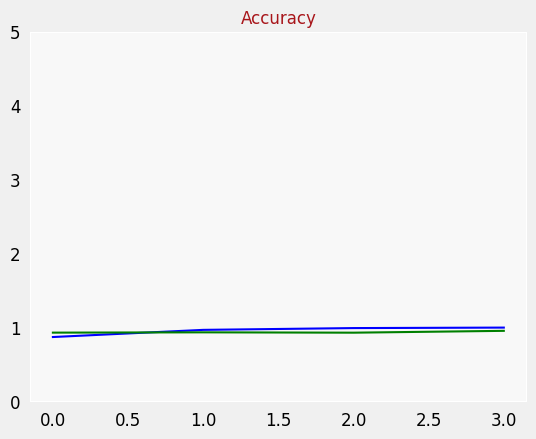

In [ ]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions

We can review the predictions on the validation set to assess the model's performance. This can help us understand how well the model generalizes to new data, providing valuable insights into its accuracy and effectiveness.

157/157 [==============================] - 27s 167ms/step


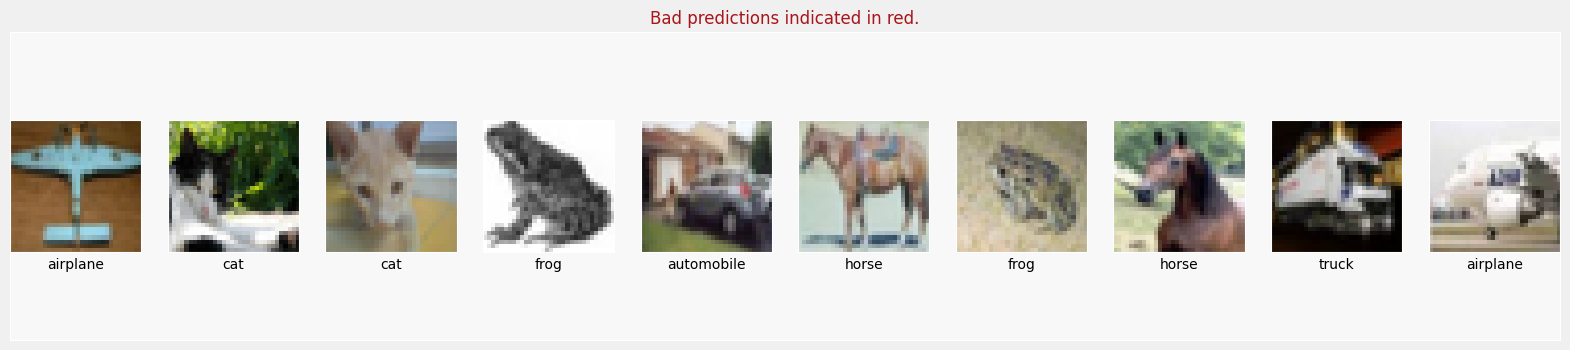

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")